In [32]:
import tensorflow as tf

# IMPORTANTE: Dejad este conjunto de lineas #
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################

Num GPUs Available:  2


In [33]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [34]:
datapath = "data/pvpcdata.csv"
day = 24

In [35]:
df = pd.read_csv(datapath, sep = ";")

In [36]:
#Due to the hour format is between 0 to 23, we need to transform it
for i in df.index:
        df.at[i, 'hour'] = df.at[i, 'hour'] - 1

In [37]:
#To keep only valid valued, not the unusual ones
df = df.loc[df['hour'] < 24]

In [38]:
cols = ["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [39]:
df.head()

,year,month,day,hour,price,date
0,2017,1,1,0,58.82,2017-1-1
1,2017,1,1,1,58.23,2017-1-1
2,2017,1,1,2,51.95,2017-1-1
3,2017,1,1,3,47.27,2017-1-1
4,2017,1,1,4,46.90,2017-1-1


In [40]:
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")

In [41]:
df = df.loc[df.date >= '2021-01-01 00:00:00']

[Text(0.5, 1.0, 'Energy prices per hour at the last day')]

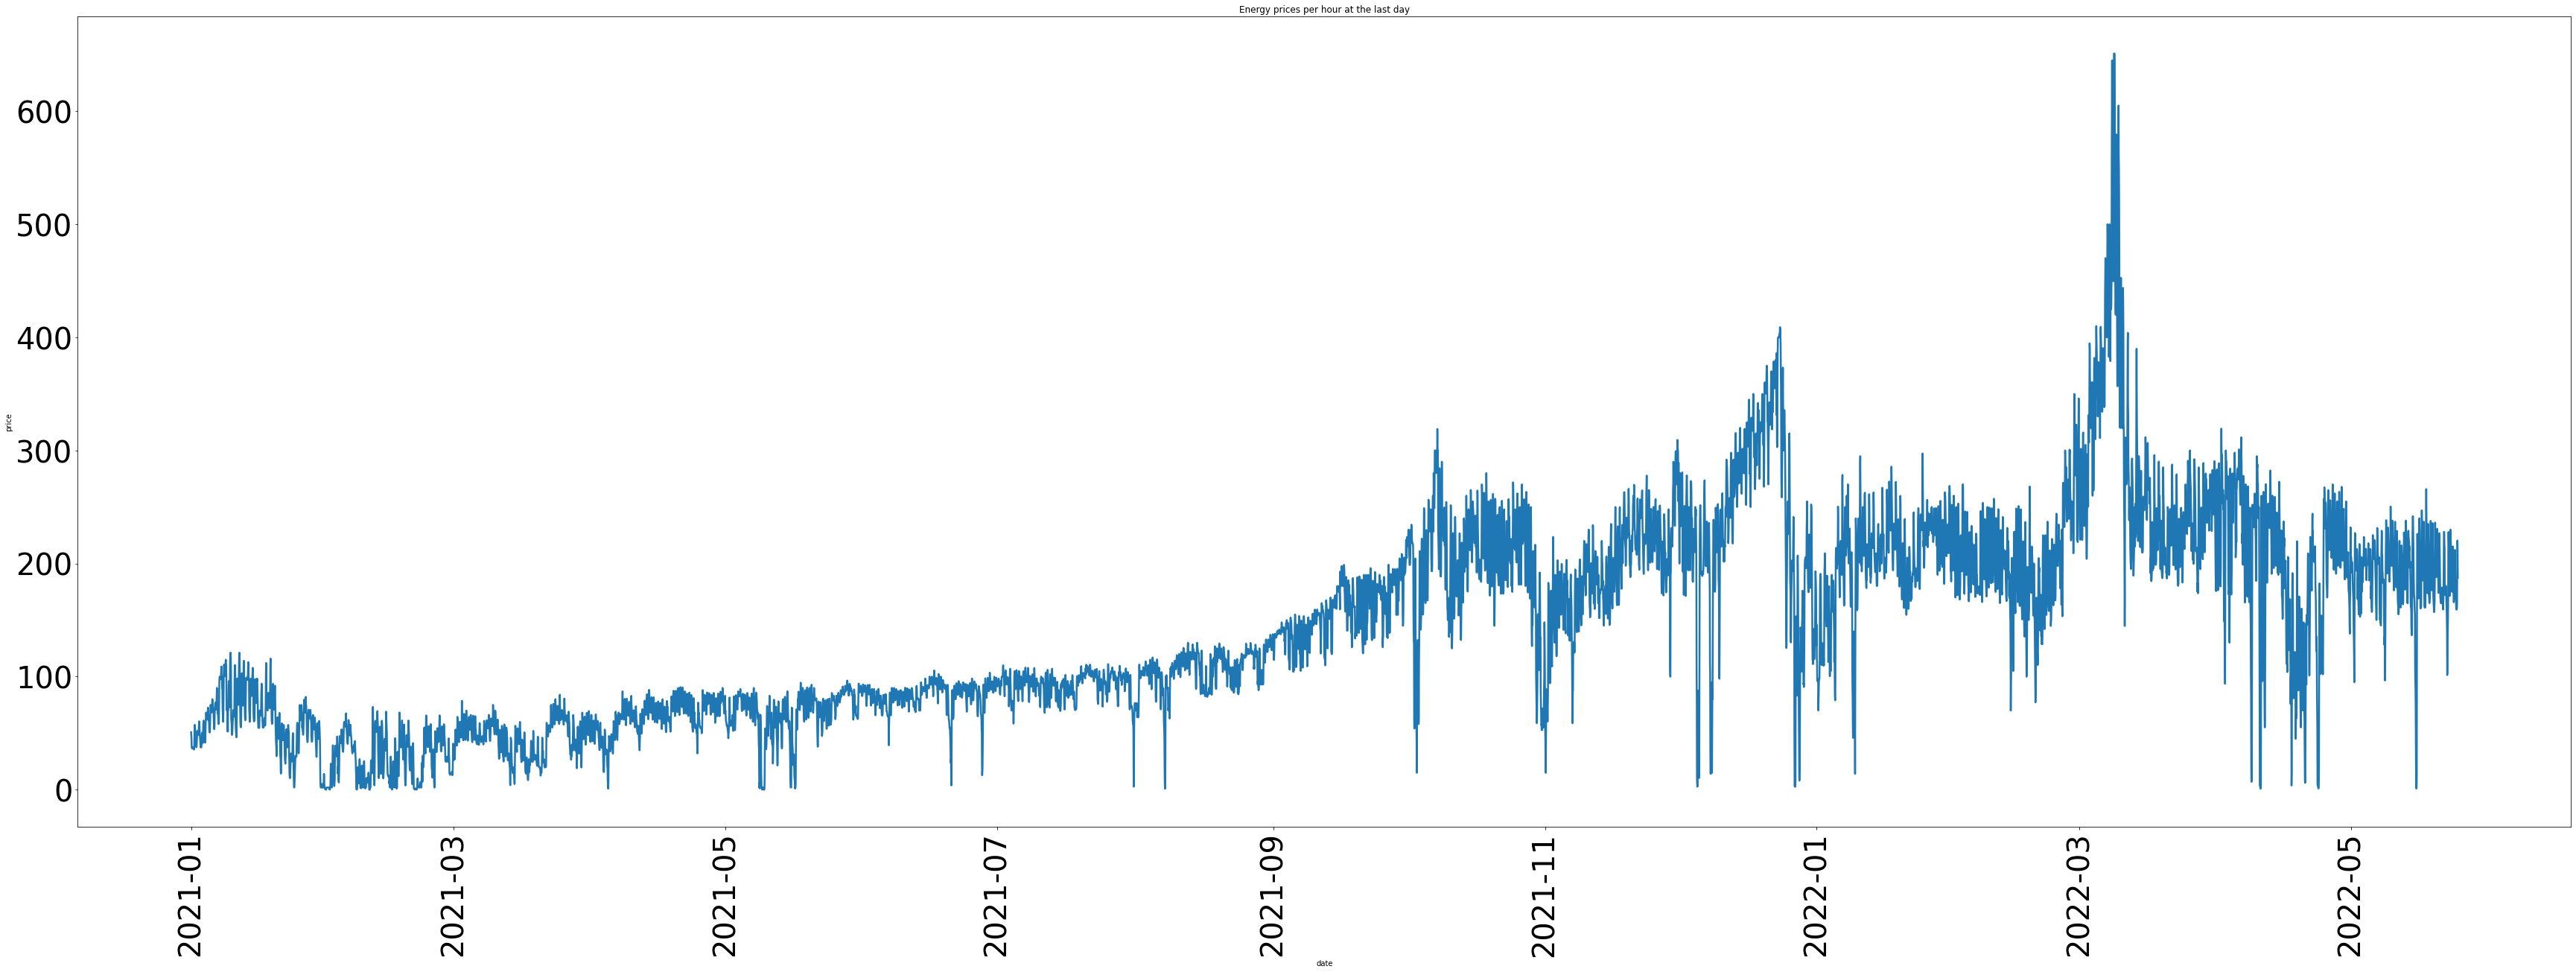

In [42]:
fig, ax = plt.subplots(figsize=(60,20))
plt.xticks(rotation=90, fontsize = 40)
plt.yticks(fontsize = 40)
sns.lineplot(x = 'date', y = 'price', data = df, linewidth = 2.5, ax = ax).set(title='Energy prices per hour at the last day')

In [43]:
df = df[['date', 'price']]

In [44]:
date = df.pop('date')

In [45]:
timestamp = date.map(datetime.datetime.timestamp)

In [46]:
sec_day = 24*60*60
sec_week = 7 * day
sec_year = 365.2425 * day

df['day_sin'] = np.sin(timestamp * (2*np.pi / sec_day))
df['day_cos'] = np.cos(timestamp * (2*np.pi / sec_day))
df['week_sin'] = np.sin(timestamp * (2*np.pi / sec_week))
df['week_cos'] = np.cos(timestamp * (2*np.pi / sec_week))
df['year_sin'] = np.sin(timestamp * (2*np.pi / sec_year))
df['year_cos'] = np.cos(timestamp * (2*np.pi / sec_year))

#Tamaño de ventana (normalmente 3 * salida)
w_size = 3 
#Número de entradas
n_inputs = len(df.columns)

In [47]:
# Método de la ventana, parámetro único en X
# Aquí podemos ver como dadas 5 horas, predice la siguiente
# [[P1, DS1, DC1, YS1, YC1],[P2...],[P3...],[P4...],[P5...] --> [P6]
# [P2,P3,P4,P5,P6] --> [P7]

def df_to_x_y_multiple(df, w_size):
    df_as_np = df.to_numpy()
    x = []
    y = []
    
    #Bucle para construir nuestra ventana simple
    for i in range(len(df_as_np) - w_size):
        row = [r for r in df_as_np[i:i + w_size]]
        x.append(row)
        
        #Solo queremos el precio
        label = df_as_np[i + w_size][0]
        y.append(label)
    
    y_array = np.array(y)
    return np.array(x), y_array.reshape((y_array.size,1))

In [48]:
x, y = df_to_x_y_multiple(df, w_size)
x.shape, y.shape

((12211, 3, 7), (12211, 1))

In [49]:
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size = 0.3, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_aux, y_aux, test_size = 0.33, shuffle=False)

In [50]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8547, 3, 7), (8547, 1), (2454, 3, 7), (2454, 1), (1210, 3, 7), (1210, 1))

In [51]:
x_mean = np.mean(x[:, :, 0])
print(x_mean)
x_std = np.std(x[:, :, 0])
print(x_std)
y_mean = np.mean(y[:, 0])
y_std = np.std(y[:, 0])

141.11900799825293
86.89524236480287


In [52]:
def standarize_input(df):
    df[:, :, 0] = (df[:, :, 0] - x_mean) / x_std
    return df

def standarize_output(df):
    df[:, 0] = (df[:, 0] - y_mean) / y_std
    return df

In [53]:
x_train_norm = standarize_input(x_train)
x_test_norm = standarize_input(x_test)
x_val_norm = standarize_input(x_val)
y_train_norm = standarize_output(y_train)
y_test_norm = standarize_output(y_test)
y_val_norm = standarize_output(y_val)


In [23]:
def build_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [24]:
def build_model_lstm_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True))
    model.add(tf.keras.layers.LSTM(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [25]:
def build_model_cnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [26]:
def build_model_cnn_relu():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2, activation = 'relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [27]:
def build_model_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [28]:
def build_model_gru_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64, return_sequences = True))
    model.add(tf.keras.layers.GRU(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [29]:
model_lstm = build_model_lstm()
model_cnn = build_model_cnn()
model_gru = build_model_gru()
model_lstm_ret_seq = build_model_lstm_ret_seq()
model_cnn_relu = build_model_cnn_relu()

2022-06-07 21:58:47.097245: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 21:58:48.101305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22357 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0
2022-06-07 21:58:48.102560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 27213 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d7:00.0, compute capability: 7.0


In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', restore_best_weights=True, patience=15)

In [31]:
history_lstm = model_lstm.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500


2022-06-07 21:58:50.276295: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


140/140 [==============================] - 3s 10ms/step - loss: 0.2987 - mae: 0.4028 - mse: 0.2987 - val_loss: 0.0917 - val_mae: 0.2170 - val_mse: 0.0917
Epoch 2/500
140/140 [==============================] - 1s 8ms/step - loss: 0.0904 - mae: 0.2226 - mse: 0.0904 - val_loss: 0.0674 - val_mae: 0.1924 - val_mse: 0.0674
Epoch 3/500
140/140 [==============================] - 1s 7ms/step - loss: 0.0702 - mae: 0.1970 - mse: 0.0702 - val_loss: 0.0604 - val_mae: 0.1876 - val_mse: 0.0604
Epoch 4/500
140/140 [==============================] - 1s 8ms/step - loss: 0.0578 - mae: 0.1772 - mse: 0.0578 - val_loss: 0.0561 - val_mae: 0.1781 - val_mse: 0.0561
Epoch 5/500
140/140 [==============================] - 1s 7ms/step - loss: 0.0535 - mae: 0.1689 - mse: 0.0535 - val_loss: 0.0515 - val_mae: 0.1686 - val_mse: 0.0515
Epoch 6/500
140/140 [==============================] - 1s 8ms/step - loss: 0.0491 - mae: 0.1606 - mse: 0.0491 - val_loss: 0.0501 - val_mae: 0.1646 - val_mse: 0.0501
Epoch 7/500
140/140 [

In [32]:
history_lstm_ret_seq = model_lstm_ret_seq.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
140/140 [==============================] - 4s 14ms/step - loss: 0.3420 - mae: 0.4523 - mse: 0.3420 - val_loss: 0.1389 - val_mae: 0.2806 - val_mse: 0.1389
Epoch 2/500
140/140 [==============================] - 1s 10ms/step - loss: 0.1396 - mae: 0.2821 - mse: 0.1396 - val_loss: 0.0873 - val_mae: 0.2139 - val_mse: 0.0873
Epoch 3/500
140/140 [==============================] - 1s 10ms/step - loss: 0.0917 - mae: 0.2261 - mse: 0.0917 - val_loss: 0.0741 - val_mae: 0.2087 - val_mse: 0.0741
Epoch 4/500
140/140 [==============================] - 1s 10ms/step - loss: 0.0795 - mae: 0.2112 - mse: 0.0795 - val_loss: 0.0696 - val_mae: 0.2017 - val_mse: 0.0696
Epoch 5/500
140/140 [==============================] - 1s 10ms/step - loss: 0.0724 - mae: 0.2013 - mse: 0.0724 - val_loss: 0.0660 - val_mae: 0.1950 - val_mse: 0.0660
Epoch 6/500
140/140 [==============================] - 1s 10ms/step - loss: 0.0675 - mae: 0.1941 - mse: 0.0675 - val_loss: 0.0619 - val_mae: 0.1872 - val_mse: 0.0619
Epoc

In [33]:
history_cnn = model_cnn.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
140/140 [==============================] - 2s 6ms/step - loss: 0.3848 - mae: 0.4429 - mse: 0.3848 - val_loss: 0.0823 - val_mae: 0.2133 - val_mse: 0.0823
Epoch 2/500
140/140 [==============================] - 1s 6ms/step - loss: 0.0963 - mae: 0.2251 - mse: 0.0963 - val_loss: 0.0567 - val_mae: 0.1811 - val_mse: 0.0567
Epoch 3/500
140/140 [==============================] - 1s 6ms/step - loss: 0.0645 - mae: 0.1874 - mse: 0.0645 - val_loss: 0.0461 - val_mae: 0.1632 - val_mse: 0.0461
Epoch 4/500
140/140 [==============================] - 1s 6ms/step - loss: 0.0499 - mae: 0.1621 - mse: 0.0499 - val_loss: 0.0422 - val_mae: 0.1551 - val_mse: 0.0422
Epoch 5/500
140/140 [==============================] - 1s 6ms/step - loss: 0.0470 - mae: 0.1562 - mse: 0.0470 - val_loss: 0.0419 - val_mae: 0.1530 - val_mse: 0.0419
Epoch 6/500
140/140 [==============================] - 1s 6ms/step - loss: 0.0464 - mae: 0.1549 - mse: 0.0464 - val_loss: 0.0413 - val_mae: 0.1508 - val_mse: 0.0413
Epoch 7/50

In [34]:
history_cnn_relu = model_cnn_relu.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
140/140 [==============================] - 1s 8ms/step - loss: 0.3967 - mae: 0.4704 - mse: 0.3967 - val_loss: 0.0937 - val_mae: 0.2278 - val_mse: 0.0937
Epoch 2/500
140/140 [==============================] - 1s 6ms/step - loss: 0.0844 - mae: 0.2137 - mse: 0.0844 - val_loss: 0.0600 - val_mae: 0.1795 - val_mse: 0.0600
Epoch 3/500
140/140 [==============================] - 1s 6ms/step - loss: 0.0575 - mae: 0.1745 - mse: 0.0575 - val_loss: 0.0494 - val_mae: 0.1643 - val_mse: 0.0494
Epoch 4/500
140/140 [==============================] - 1s 6ms/step - loss: 0.0497 - mae: 0.1620 - mse: 0.0497 - val_loss: 0.0465 - val_mae: 0.1579 - val_mse: 0.0465
Epoch 5/500
140/140 [==============================] - 1s 6ms/step - loss: 0.0456 - mae: 0.1543 - mse: 0.0456 - val_loss: 0.0436 - val_mae: 0.1524 - val_mse: 0.0436
Epoch 6/500
140/140 [==============================] - 1s 6ms/step - loss: 0.0428 - mae: 0.1482 - mse: 0.0428 - val_loss: 0.0419 - val_mae: 0.1481 - val_mse: 0.0419
Epoch 7/50

In [35]:
history_gru = model_gru.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
140/140 [==============================] - 2s 9ms/step - loss: 0.2027 - mae: 0.3445 - mse: 0.2027 - val_loss: 0.0912 - val_mae: 0.2187 - val_mse: 0.0912
Epoch 2/500
140/140 [==============================] - 1s 7ms/step - loss: 0.0804 - mae: 0.2093 - mse: 0.0804 - val_loss: 0.0568 - val_mae: 0.1716 - val_mse: 0.0568
Epoch 3/500
140/140 [==============================] - 1s 7ms/step - loss: 0.0553 - mae: 0.1714 - mse: 0.0553 - val_loss: 0.0466 - val_mae: 0.1570 - val_mse: 0.0466
Epoch 4/500
140/140 [==============================] - 1s 7ms/step - loss: 0.0484 - mae: 0.1585 - mse: 0.0484 - val_loss: 0.0411 - val_mae: 0.1460 - val_mse: 0.0411
Epoch 5/500
140/140 [==============================] - 1s 7ms/step - loss: 0.0449 - mae: 0.1506 - mse: 0.0449 - val_loss: 0.0379 - val_mae: 0.1392 - val_mse: 0.0379
Epoch 6/500
140/140 [==============================] - 1s 7ms/step - loss: 0.0436 - mae: 0.1474 - mse: 0.0436 - val_loss: 0.0367 - val_mae: 0.1365 - val_mse: 0.0367
Epoch 7/50

In [36]:
def plot_history(history, y_min, y_loss, y_mae, y_mse):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #Graphic of Loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    plt.plot(hist['epoch'], hist['loss'], label='Loss Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.ylim([y_min,y_loss])
    plt.legend()
    
    #Graphic of MAE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([y_min,y_mae])
    plt.legend()
    
    #Graphic of MSE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([y_min,y_mse])
    plt.legend()
    
    
    plt.show()

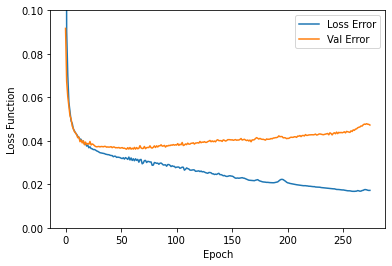

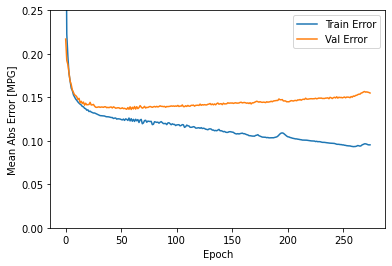

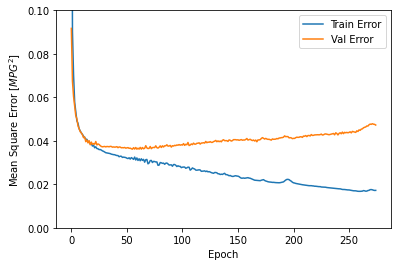

In [37]:
plot_history(history_lstm, 0, 0.1, 0.25, 0.1)

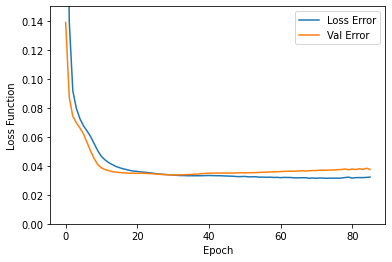

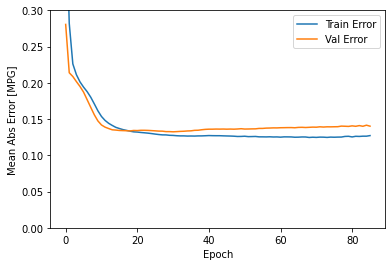

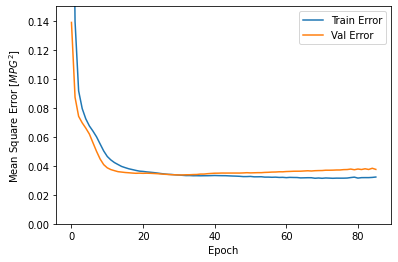

In [38]:
plot_history(history_lstm_ret_seq, 0, 0.15, 0.3, 0.15)

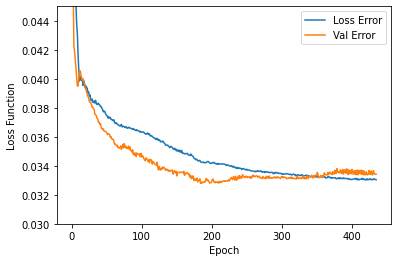

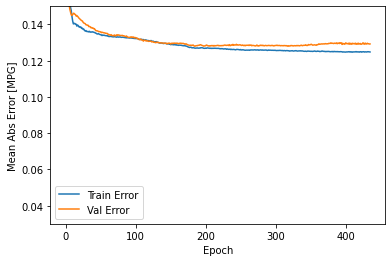

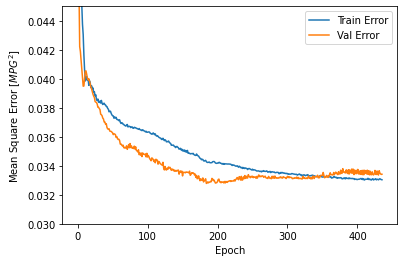

In [56]:
plot_history(history_cnn, 0.03, 0.045, 0.15, 0.045)

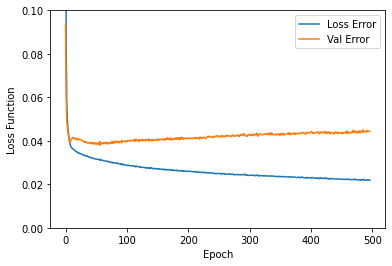

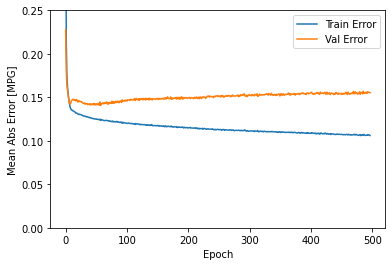

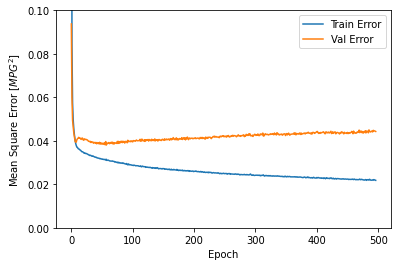

In [40]:
plot_history(history_cnn_relu, 0, 0.1, 0.25, 0.1)

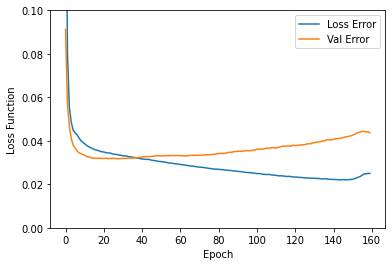

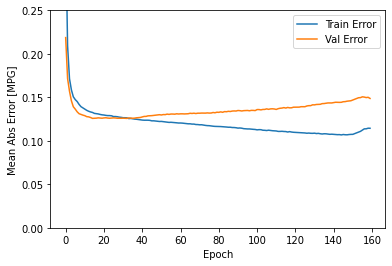

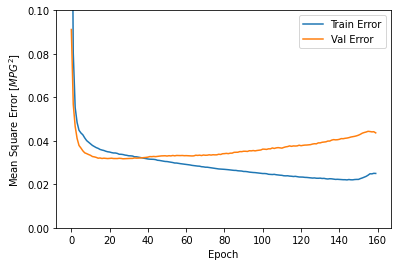

In [41]:
plot_history(history_gru, 0, 0.1, 0.25, 0.1)

In [42]:
y_pred_lstm = model_lstm.predict(x_test_norm)
y_pred_cnn = model_cnn.predict(x_test_norm)
y_pred_gru = model_gru.predict(x_test_norm)
y_pred_lstm_ret_seq = model_lstm_ret_seq.predict(x_test_norm)
y_pred_cnn_relu = model_cnn_relu.predict(x_test_norm)

In [43]:
def inverse_standarize_input(arr):
    arr = (arr * y_std) + y_mean
    return arr

In [44]:
y_pred_lstm = inverse_standarize_input(y_pred_lstm)
y_pred_cnn = inverse_standarize_input(y_pred_cnn)
y_pred_gru = inverse_standarize_input(y_pred_gru)
y_pred_lstm_ret_seq = inverse_standarize_input(y_pred_lstm_ret_seq)
y_pred_cnn_relu = inverse_standarize_input(y_pred_cnn_relu)
y_test = inverse_standarize_input(y_test_norm)

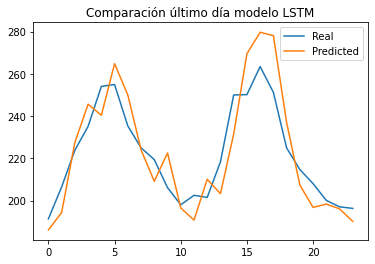

In [45]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM")
plt.legend()

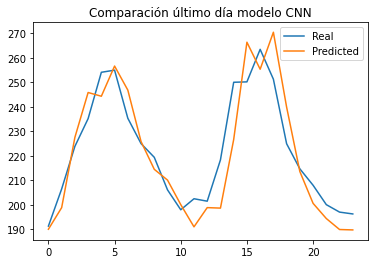

In [46]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN")
plt.legend()

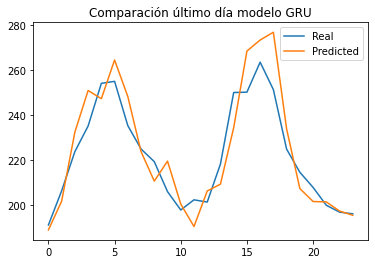

In [47]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_gru[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo GRU")
plt.legend()

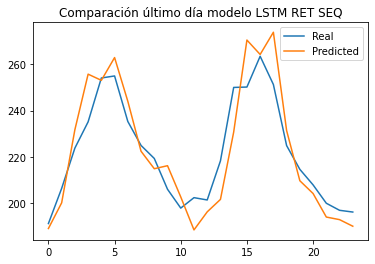

In [48]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_ret_seq[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM RET SEQ")
plt.legend()

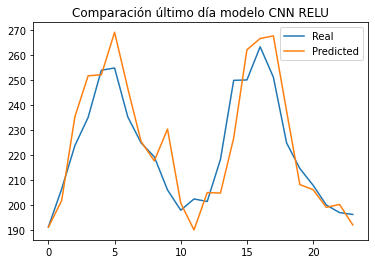

In [49]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn_relu[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN RELU")
plt.legend()

In [50]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_lstm_ret_seq = np.sqrt(mean_squared_error(y_test, y_pred_lstm_ret_seq))
mae_lstm_ret_seq = mean_absolute_error(y_test, y_pred_lstm_ret_seq)
rmse_cnn_relu = np.sqrt(mean_squared_error(y_test, y_pred_cnn_relu))
mae_cnn_relu = mean_absolute_error(y_test, y_pred_cnn_relu)

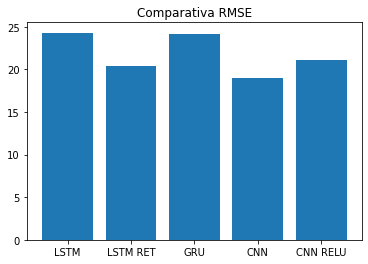

In [51]:
x_axis = ["LSTM", "LSTM RET", "GRU", "CNN", "CNN RELU"]
y_axis = [rmse_lstm, rmse_lstm_ret_seq, rmse_gru, rmse_cnn, rmse_cnn_relu]
plt.title("Comparativa RMSE")
plt.bar(x_axis, y_axis)
plt.show()

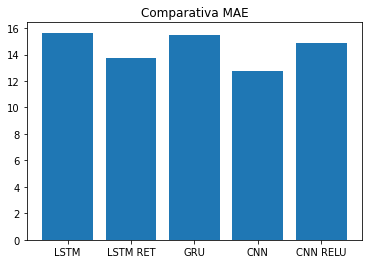

In [52]:
x_axis = ["LSTM", "LSTM RET", "GRU", "CNN", "CNN RELU"]
y_axis = [mae_lstm, mae_lstm_ret_seq, mae_gru, mae_cnn, mae_cnn_relu]
plt.title("Comparativa MAE")
plt.bar(x_axis, y_axis)
plt.show()

In [53]:
model_lstm.save("normalized_multiple_input/LSTM.h5")
model_cnn.save("normalized_multiple_input/CNN.h5")
model_gru.save("normalized_multiple_input/GRU.h5")
model_lstm_ret_seq.save("normalized_multiple_input/LSTM_RET_SEQ.h5")
model_cnn_relu.save("normalized_multiple_input/CNN_RELU.h5")

In [54]:
df['date'] = timestamp

In [55]:
for i in df.index:
        df.at[i, 'price'] = (df.at[i, 'price'] - x_mean) / x_std

In [56]:
print(df.head)

<bound method NDFrame.head of           price       day_sin       day_cos      week_sin  week_cos  year_sin  \
35088 -1.038596 -2.588190e-01  9.659258e-01 -7.818315e-01  0.623490 -0.895167   
35089 -1.069437 -6.012051e-12  1.000000e+00  9.749279e-01 -0.222521  0.995085   
35090 -1.109831  2.588190e-01  9.659258e-01 -9.749279e-01 -0.222521 -0.789771   
35091 -1.180951  5.000000e-01  8.660254e-01  7.818315e-01  0.623490  0.342202   
35092 -1.200515  7.071068e-01  7.071068e-01 -4.338837e-01 -0.900969  0.210334   
...         ...           ...           ...           ...       ...       ...   
47298  0.246515 -9.659258e-01 -2.588190e-01 -9.749279e-01 -0.222521  0.950645   
47299  0.612013 -1.000000e+00 -1.283175e-11  7.818315e-01  0.623490 -0.969970   
47300  0.911224 -9.659258e-01  2.588190e-01 -4.338837e-01 -0.900969  0.691766   
47301  0.814671 -8.660254e-01  5.000000e-01  4.569656e-09  1.000000 -0.201370   
47302  0.532607 -7.071068e-01  7.071068e-01  4.338837e-01 -0.900969 -0.350795  

In [57]:
df.to_csv (r'csvdata2021.csv', index = False, header=True)